In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'random_occlusion'}
Validation folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'random_occlusion'}
Test folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'random_occlusion'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise'}
Validation folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise'}
Test folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Fixed Xception Architecture from Scratch
# -----------------------------

class SeparableConv2d(nn.Module):
    """Depthwise Separable Convolution - Core of Xception"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=bias)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class XceptionBlock(nn.Module):
    """Fixed Xception Block with skip connections"""
    def __init__(self, in_channels, out_channels, reps, stride=1, start_with_relu=True, grow_first=True):
        super(XceptionBlock, self).__init__()
        
        # Skip connection if needed
        self.skip = None
        if out_channels != in_channels or stride != 1:
            self.skip = nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False)
            self.skipbn = nn.BatchNorm2d(out_channels)
        
        rep = []
        filters = in_channels
        
        if grow_first:
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(out_channels))
            filters = out_channels

        for i in range(reps - 1):
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(out_channels))

        if stride != 1:
            rep.append(nn.MaxPool2d(3, stride=stride, padding=1))
        
        self.rep = nn.Sequential(*rep)

    def forward(self, x):
        output = self.rep(x)
        
        if self.skip is not None:
            skip = self.skip(x)
            skip = self.skipbn(skip)
        else:
            skip = x
        
        output += skip
        return output

class Xception(nn.Module):
    """Fixed Xception Network Architecture from Scratch"""
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()
        
        # Entry Flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=False)  # FIXED: inplace=False
        
        self.conv2 = nn.Conv2d(32, 64, 3, bias=False, padding=1)  # FIXED: added padding
        self.bn2 = nn.BatchNorm2d(64)
        
        self.block1 = XceptionBlock(64, 128, 2, stride=2, start_with_relu=False, grow_first=True)
        self.block2 = XceptionBlock(128, 256, 2, stride=2, start_with_relu=True, grow_first=True)
        self.block3 = XceptionBlock(256, 728, 2, stride=2, start_with_relu=True, grow_first=True)
        
        # Middle Flow (repeated 8 times)
        self.block4 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block5 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block6 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block7 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block8 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block9 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block10 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block11 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        
        # Exit Flow
        self.block12 = XceptionBlock(728, 1024, 2, stride=2, start_with_relu=True, grow_first=False)
        
        self.conv3 = SeparableConv2d(1024, 1536, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(1536)
        
        self.conv4 = SeparableConv2d(1536, 2048, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(2048)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, num_classes)
        
        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Entry Flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Middle Flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        
        # Exit Flow
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        # Final classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# -----------------------------
# 2. Data Preprocessing with Filtering (Xception - 299x299)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# Xception training from scratch - with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation for scratch training
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

transform_val_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("🔄 Loading and filtering datasets for Xception (scratch training)...")
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform_train)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform_val_test)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform_val_test)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)  # Smaller batch for scratch training
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"✅ Classes: {classes}")
print(f"📊 Dataset Statistics:")
print(f"│ Training images: {len(train_ds)}")
print(f"│ Validation images: {len(val_ds)}")
print(f"│ Test images: {len(test_ds)}")
print(f"│ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"│ Excluded folder: '{ignore_folder}'")
print(f"│ Number of classes: {len(classes)}")

# -----------------------------
# 3. Model Setup for Scratch Training
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create Xception model from scratch
print("🔄 Creating Xception model from scratch...")
model = Xception(num_classes=len(classes))
model = model.to(device)

print(f"✅ Model created with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 299, 299)")
print(f"│ Xception features: 2048")
print(f"│ Output classes: {len(classes)}")
print(f"│ Training: From scratch (no pretrained weights)")
print(f"│ Data augmentation: Enabled for robust training")

🔄 Loading and filtering datasets for Xception (scratch training)...
✅ Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']
📊 Dataset Statistics:
│ Training images: 9928
│ Validation images: 2576
│ Test images: 3224
│ Total images (after filtering): 15728
│ Excluded folder: 'random_occlusion'
│ Number of classes: 4
Using device: cuda
🔄 Creating Xception model from scratch...
✅ Model created with 4 output classes
📊 Total parameters: 20,815,148
📊 Trainable parameters: 20,815,148
📋 Model Architecture:
│ Input size: (3, 299, 299)
│ Xception features: 2048
│ Output classes: 4
│ Training: From scratch (no pretrained weights)
│ Data augmentation: Enabled for robust training



📋 Training Configuration:
│ Model: Xception (from scratch)
│ Optimizer: Adam (lr=0.001)
│ Weight Decay: 1e-4
│ Loss Function: CrossEntropyLoss
│ Batch Size: 16
│ LR Scheduler: StepLR (decay every 10 epochs)
│ Device: cuda
│ Data: Filtered + Augmented

🚀 Starting Xception Training from Scratch for 50 epochs...

📈 Epoch 1/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:33<00:00,  1.65s/it, Loss=1.1390, Acc=0.5183, GPU=0.3GB]


✅ Training completed in 513.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:50<00:00,  1.59it/s, Loss=1.1206, Acc=0.5532]


✅ Validation completed in 50.93s
🌟 New best model found! Validation Accuracy: 0.5532

📊 Epoch 1 Summary:
│ Train Loss: 1.1390 | Train Acc: 0.5183
│ Val Loss:   1.1206 | Val Acc:   0.5532
│ Train Time: 513.20s | Val Time: 50.93s
│ Total Epoch Time: 564.14s
│ Best Val Acc: 0.5532 (Epoch 1)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 2/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:14<00:00,  1.59s/it, Loss=1.0315, Acc=0.5734, GPU=0.3GB]


✅ Training completed in 494.54s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=1.0824, Acc=0.5656]


✅ Validation completed in 44.76s
🌟 New best model found! Validation Accuracy: 0.5656

📊 Epoch 2 Summary:
│ Train Loss: 1.0315 | Train Acc: 0.5734
│ Val Loss:   1.0824 | Val Acc:   0.5656
│ Train Time: 494.54s | Val Time: 44.76s
│ Total Epoch Time: 539.31s
│ Best Val Acc: 0.5656 (Epoch 2)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 3/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:14<00:00,  1.59s/it, Loss=0.9273, Acc=0.6234, GPU=0.3GB]


✅ Training completed in 494.94s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=1.0715, Acc=0.5951]


✅ Validation completed in 44.71s
🌟 New best model found! Validation Accuracy: 0.5951

📊 Epoch 3 Summary:
│ Train Loss: 0.9273 | Train Acc: 0.6234
│ Val Loss:   1.0715 | Val Acc:   0.5951
│ Train Time: 494.94s | Val Time: 44.71s
│ Total Epoch Time: 539.66s
│ Best Val Acc: 0.5951 (Epoch 3)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 4/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:13<00:00,  1.59s/it, Loss=0.8062, Acc=0.6681, GPU=0.3GB]


✅ Training completed in 493.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=1.2679, Acc=0.5734]


✅ Validation completed in 44.47s

📊 Epoch 4 Summary:
│ Train Loss: 0.8062 | Train Acc: 0.6681
│ Val Loss:   1.2679 | Val Acc:   0.5734
│ Train Time: 493.22s | Val Time: 44.47s
│ Total Epoch Time: 537.69s
│ Best Val Acc: 0.5951 (Epoch 3)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 5/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:14<00:00,  1.59s/it, Loss=0.7298, Acc=0.7106, GPU=0.3GB]


✅ Training completed in 494.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.9188, Acc=0.6231]


✅ Validation completed in 44.74s
🌟 New best model found! Validation Accuracy: 0.6231

📊 Epoch 5 Summary:
│ Train Loss: 0.7298 | Train Acc: 0.7106
│ Val Loss:   0.9188 | Val Acc:   0.6231
│ Train Time: 494.02s | Val Time: 44.74s
│ Total Epoch Time: 538.77s
│ Best Val Acc: 0.6231 (Epoch 5)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 6/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:16<00:00,  1.60s/it, Loss=0.6428, Acc=0.7440, GPU=0.3GB]


✅ Training completed in 496.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:45<00:00,  1.78it/s, Loss=0.9085, Acc=0.6689]


✅ Validation completed in 45.45s
🌟 New best model found! Validation Accuracy: 0.6689

📊 Epoch 6 Summary:
│ Train Loss: 0.6428 | Train Acc: 0.7440
│ Val Loss:   0.9085 | Val Acc:   0.6689
│ Train Time: 496.26s | Val Time: 45.45s
│ Total Epoch Time: 541.71s
│ Best Val Acc: 0.6689 (Epoch 6)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 7/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:13<00:00,  1.59s/it, Loss=0.5426, Acc=0.7910, GPU=0.3GB]


✅ Training completed in 493.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:45<00:00,  1.79it/s, Loss=0.7182, Acc=0.7259]


✅ Validation completed in 45.27s
🌟 New best model found! Validation Accuracy: 0.7259

📊 Epoch 7 Summary:
│ Train Loss: 0.5426 | Train Acc: 0.7910
│ Val Loss:   0.7182 | Val Acc:   0.7259
│ Train Time: 493.15s | Val Time: 45.27s
│ Total Epoch Time: 538.43s
│ Best Val Acc: 0.7259 (Epoch 7)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 8/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:13<00:00,  1.59s/it, Loss=0.4699, Acc=0.8228, GPU=0.3GB]


✅ Training completed in 493.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:45<00:00,  1.79it/s, Loss=0.6664, Acc=0.7562]


✅ Validation completed in 45.30s
🌟 New best model found! Validation Accuracy: 0.7562

📊 Epoch 8 Summary:
│ Train Loss: 0.4699 | Train Acc: 0.8228
│ Val Loss:   0.6664 | Val Acc:   0.7562
│ Train Time: 493.51s | Val Time: 45.30s
│ Total Epoch Time: 538.81s
│ Best Val Acc: 0.7562 (Epoch 8)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 9/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:12<00:00,  1.58s/it, Loss=0.3754, Acc=0.8599, GPU=0.3GB]


✅ Training completed in 492.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:45<00:00,  1.80it/s, Loss=0.8454, Acc=0.7290]


✅ Validation completed in 45.01s

📊 Epoch 9 Summary:
│ Train Loss: 0.3754 | Train Acc: 0.8599
│ Val Loss:   0.8454 | Val Acc:   0.7290
│ Train Time: 492.84s | Val Time: 45.01s
│ Total Epoch Time: 537.85s
│ Best Val Acc: 0.7562 (Epoch 8)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 10/50
Current LR: 1.00e-03
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:15<00:00,  1.59s/it, Loss=0.3284, Acc=0.8768, GPU=0.3GB]


✅ Training completed in 495.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.80it/s, Loss=0.6751, Acc=0.7554]


✅ Validation completed in 44.94s

📊 Epoch 10 Summary:
│ Train Loss: 0.3284 | Train Acc: 0.8768
│ Val Loss:   0.6751 | Val Acc:   0.7554
│ Train Time: 495.06s | Val Time: 44.94s
│ Total Epoch Time: 540.00s
│ Best Val Acc: 0.7562 (Epoch 8)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 11/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:12<00:00,  1.58s/it, Loss=0.1784, Acc=0.9360, GPU=0.3GB]


✅ Training completed in 492.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.6131, Acc=0.7915]


✅ Validation completed in 44.67s
🌟 New best model found! Validation Accuracy: 0.7915

📊 Epoch 11 Summary:
│ Train Loss: 0.1784 | Train Acc: 0.9360
│ Val Loss:   0.6131 | Val Acc:   0.7915
│ Train Time: 492.42s | Val Time: 44.67s
│ Total Epoch Time: 537.10s
│ Best Val Acc: 0.7915 (Epoch 11)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 12/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:09<00:00,  1.58s/it, Loss=0.1281, Acc=0.9570, GPU=0.3GB]


✅ Training completed in 489.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.6329, Acc=0.7900]


✅ Validation completed in 44.61s

📊 Epoch 12 Summary:
│ Train Loss: 0.1281 | Train Acc: 0.9570
│ Val Loss:   0.6329 | Val Acc:   0.7900
│ Train Time: 489.91s | Val Time: 44.61s
│ Total Epoch Time: 534.52s
│ Best Val Acc: 0.7915 (Epoch 11)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 13/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:10<00:00,  1.58s/it, Loss=0.1088, Acc=0.9622, GPU=0.3GB]


✅ Training completed in 490.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.6507, Acc=0.7993]


✅ Validation completed in 44.59s
🌟 New best model found! Validation Accuracy: 0.7993

📊 Epoch 13 Summary:
│ Train Loss: 0.1088 | Train Acc: 0.9622
│ Val Loss:   0.6507 | Val Acc:   0.7993
│ Train Time: 490.23s | Val Time: 44.59s
│ Total Epoch Time: 534.83s
│ Best Val Acc: 0.7993 (Epoch 13)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 14/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0967, Acc=0.9697, GPU=0.3GB]


✅ Training completed in 490.83s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.6919, Acc=0.7927]


✅ Validation completed in 44.88s

📊 Epoch 14 Summary:
│ Train Loss: 0.0967 | Train Acc: 0.9697
│ Val Loss:   0.6919 | Val Acc:   0.7927
│ Train Time: 490.83s | Val Time: 44.88s
│ Total Epoch Time: 535.71s
│ Best Val Acc: 0.7993 (Epoch 13)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 15/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0844, Acc=0.9746, GPU=0.3GB]


✅ Training completed in 490.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.6926, Acc=0.8063]


✅ Validation completed in 44.65s
🌟 New best model found! Validation Accuracy: 0.8063

📊 Epoch 15 Summary:
│ Train Loss: 0.0844 | Train Acc: 0.9746
│ Val Loss:   0.6926 | Val Acc:   0.8063
│ Train Time: 490.79s | Val Time: 44.65s
│ Total Epoch Time: 535.45s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 16/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0782, Acc=0.9757, GPU=0.3GB]


✅ Training completed in 497.85s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.71it/s, Loss=0.7140, Acc=0.7977]


✅ Validation completed in 47.41s

📊 Epoch 16 Summary:
│ Train Loss: 0.0782 | Train Acc: 0.9757
│ Val Loss:   0.7140 | Val Acc:   0.7977
│ Train Time: 497.85s | Val Time: 47.41s
│ Total Epoch Time: 545.26s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 17/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0675, Acc=0.9784, GPU=0.3GB]


✅ Training completed in 497.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.69it/s, Loss=0.7479, Acc=0.7884]


✅ Validation completed in 47.80s

📊 Epoch 17 Summary:
│ Train Loss: 0.0675 | Train Acc: 0.9784
│ Val Loss:   0.7479 | Val Acc:   0.7884
│ Train Time: 497.80s | Val Time: 47.80s
│ Total Epoch Time: 545.60s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 18/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0656, Acc=0.9778, GPU=0.3GB]


✅ Training completed in 497.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:48<00:00,  1.69it/s, Loss=0.7616, Acc=0.7892]


✅ Validation completed in 48.03s

📊 Epoch 18 Summary:
│ Train Loss: 0.0656 | Train Acc: 0.9778
│ Val Loss:   0.7616 | Val Acc:   0.7892
│ Train Time: 497.23s | Val Time: 48.03s
│ Total Epoch Time: 545.26s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 19/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:15<00:00,  1.59s/it, Loss=0.0552, Acc=0.9820, GPU=0.3GB]


✅ Training completed in 495.57s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.70it/s, Loss=0.7802, Acc=0.7884]


✅ Validation completed in 47.71s

📊 Epoch 19 Summary:
│ Train Loss: 0.0552 | Train Acc: 0.9820
│ Val Loss:   0.7802 | Val Acc:   0.7884
│ Train Time: 495.57s | Val Time: 47.71s
│ Total Epoch Time: 543.28s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 20/50
Current LR: 1.00e-04
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0537, Acc=0.9855, GPU=0.3GB]


✅ Training completed in 497.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8671, Acc=0.7900]


✅ Validation completed in 47.80s

📊 Epoch 20 Summary:
│ Train Loss: 0.0537 | Train Acc: 0.9855
│ Val Loss:   0.8671 | Val Acc:   0.7900
│ Train Time: 497.80s | Val Time: 47.80s
│ Total Epoch Time: 545.60s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 21/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:13<00:00,  1.59s/it, Loss=0.0471, Acc=0.9851, GPU=0.3GB]


✅ Training completed in 493.75s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8374, Acc=0.7904]


✅ Validation completed in 44.62s

📊 Epoch 21 Summary:
│ Train Loss: 0.0471 | Train Acc: 0.9851
│ Val Loss:   0.8374 | Val Acc:   0.7904
│ Train Time: 493.75s | Val Time: 44.62s
│ Total Epoch Time: 538.38s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 22/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:12<00:00,  1.58s/it, Loss=0.0426, Acc=0.9875, GPU=0.3GB]


✅ Training completed in 492.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8251, Acc=0.7927]


✅ Validation completed in 47.88s

📊 Epoch 22 Summary:
│ Train Loss: 0.0426 | Train Acc: 0.9875
│ Val Loss:   0.8251 | Val Acc:   0.7927
│ Train Time: 492.01s | Val Time: 47.88s
│ Total Epoch Time: 539.90s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 23/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:18<00:00,  1.60s/it, Loss=0.0388, Acc=0.9876, GPU=0.3GB]


✅ Training completed in 498.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:46<00:00,  1.74it/s, Loss=0.8211, Acc=0.7888]


✅ Validation completed in 46.51s

📊 Epoch 23 Summary:
│ Train Loss: 0.0388 | Train Acc: 0.9876
│ Val Loss:   0.8211 | Val Acc:   0.7888
│ Train Time: 498.23s | Val Time: 46.51s
│ Total Epoch Time: 544.75s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 24/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0412, Acc=0.9863, GPU=0.3GB]


✅ Training completed in 490.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.72it/s, Loss=0.8461, Acc=0.7931]


✅ Validation completed in 47.01s

📊 Epoch 24 Summary:
│ Train Loss: 0.0412 | Train Acc: 0.9863
│ Val Loss:   0.8461 | Val Acc:   0.7931
│ Train Time: 490.17s | Val Time: 47.01s
│ Total Epoch Time: 537.19s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 25/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0390, Acc=0.9882, GPU=0.3GB]


✅ Training completed in 497.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:48<00:00,  1.69it/s, Loss=0.8296, Acc=0.7904]


✅ Validation completed in 48.03s

📊 Epoch 25 Summary:
│ Train Loss: 0.0390 | Train Acc: 0.9882
│ Val Loss:   0.8296 | Val Acc:   0.7904
│ Train Time: 497.82s | Val Time: 48.03s
│ Total Epoch Time: 545.86s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 26/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0347, Acc=0.9897, GPU=0.3GB]


✅ Training completed in 497.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.72it/s, Loss=0.8338, Acc=0.7892]


✅ Validation completed in 47.19s

📊 Epoch 26 Summary:
│ Train Loss: 0.0347 | Train Acc: 0.9897
│ Val Loss:   0.8338 | Val Acc:   0.7892
│ Train Time: 497.14s | Val Time: 47.19s
│ Total Epoch Time: 544.34s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 27/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:14<00:00,  1.59s/it, Loss=0.0370, Acc=0.9883, GPU=0.3GB]


✅ Training completed in 494.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:46<00:00,  1.73it/s, Loss=0.8360, Acc=0.7915]


✅ Validation completed in 46.81s

📊 Epoch 27 Summary:
│ Train Loss: 0.0370 | Train Acc: 0.9883
│ Val Loss:   0.8360 | Val Acc:   0.7915
│ Train Time: 494.92s | Val Time: 46.81s
│ Total Epoch Time: 541.73s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 28/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:09<00:00,  1.57s/it, Loss=0.0333, Acc=0.9901, GPU=0.3GB]


✅ Training completed in 489.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8248, Acc=0.7896]


✅ Validation completed in 44.73s

📊 Epoch 28 Summary:
│ Train Loss: 0.0333 | Train Acc: 0.9901
│ Val Loss:   0.8248 | Val Acc:   0.7896
│ Train Time: 489.18s | Val Time: 44.73s
│ Total Epoch Time: 533.92s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 29/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [09:02<00:00,  1.74s/it, Loss=0.0348, Acc=0.9879, GPU=0.3GB]


✅ Training completed in 542.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [01:17<00:00,  1.04it/s, Loss=0.8291, Acc=0.7849]


✅ Validation completed in 77.63s

📊 Epoch 29 Summary:
│ Train Loss: 0.0348 | Train Acc: 0.9879
│ Val Loss:   0.8291 | Val Acc:   0.7849
│ Train Time: 542.68s | Val Time: 77.63s
│ Total Epoch Time: 620.31s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 30/50
Current LR: 1.00e-05
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [09:22<00:00,  1.81s/it, Loss=0.0316, Acc=0.9903, GPU=0.3GB]


✅ Training completed in 562.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.70it/s, Loss=0.8452, Acc=0.7927]


✅ Validation completed in 47.70s

📊 Epoch 30 Summary:
│ Train Loss: 0.0316 | Train Acc: 0.9903
│ Val Loss:   0.8452 | Val Acc:   0.7927
│ Train Time: 562.11s | Val Time: 47.70s
│ Total Epoch Time: 609.81s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 31/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:14<00:00,  1.59s/it, Loss=0.0329, Acc=0.9904, GPU=0.3GB]


✅ Training completed in 494.83s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.71it/s, Loss=0.8876, Acc=0.7869]


✅ Validation completed in 47.33s

📊 Epoch 31 Summary:
│ Train Loss: 0.0329 | Train Acc: 0.9904
│ Val Loss:   0.8876 | Val Acc:   0.7869
│ Train Time: 494.83s | Val Time: 47.33s
│ Total Epoch Time: 542.16s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 32/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:26<00:00,  1.63s/it, Loss=0.0391, Acc=0.9874, GPU=0.3GB]


✅ Training completed in 506.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.70it/s, Loss=0.8593, Acc=0.7896]


✅ Validation completed in 47.74s

📊 Epoch 32 Summary:
│ Train Loss: 0.0391 | Train Acc: 0.9874
│ Val Loss:   0.8593 | Val Acc:   0.7896
│ Train Time: 506.22s | Val Time: 47.74s
│ Total Epoch Time: 553.97s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 33/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:13<00:00,  1.59s/it, Loss=0.0339, Acc=0.9897, GPU=0.3GB]


✅ Training completed in 493.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:45<00:00,  1.79it/s, Loss=0.8570, Acc=0.7861]


✅ Validation completed in 45.14s

📊 Epoch 33 Summary:
│ Train Loss: 0.0339 | Train Acc: 0.9897
│ Val Loss:   0.8570 | Val Acc:   0.7861
│ Train Time: 493.77s | Val Time: 45.14s
│ Total Epoch Time: 538.91s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 34/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:11<00:00,  1.58s/it, Loss=0.0353, Acc=0.9889, GPU=0.3GB]


✅ Training completed in 491.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8558, Acc=0.7927]


✅ Validation completed in 44.72s

📊 Epoch 34 Summary:
│ Train Loss: 0.0353 | Train Acc: 0.9889
│ Val Loss:   0.8558 | Val Acc:   0.7927
│ Train Time: 491.79s | Val Time: 44.72s
│ Total Epoch Time: 536.51s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 35/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0306, Acc=0.9904, GPU=0.3GB]


✅ Training completed in 486.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8585, Acc=0.7923]


✅ Validation completed in 44.75s

📊 Epoch 35 Summary:
│ Train Loss: 0.0306 | Train Acc: 0.9904
│ Val Loss:   0.8585 | Val Acc:   0.7923
│ Train Time: 486.41s | Val Time: 44.75s
│ Total Epoch Time: 531.16s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 36/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:07<00:00,  1.57s/it, Loss=0.0324, Acc=0.9904, GPU=0.3GB]


✅ Training completed in 487.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.83it/s, Loss=0.8458, Acc=0.7853]


✅ Validation completed in 44.38s

📊 Epoch 36 Summary:
│ Train Loss: 0.0324 | Train Acc: 0.9904
│ Val Loss:   0.8458 | Val Acc:   0.7853
│ Train Time: 487.22s | Val Time: 44.38s
│ Total Epoch Time: 531.60s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 37/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0329, Acc=0.9902, GPU=0.3GB]


✅ Training completed in 490.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8569, Acc=0.7896]


✅ Validation completed in 44.58s

📊 Epoch 37 Summary:
│ Train Loss: 0.0329 | Train Acc: 0.9902
│ Val Loss:   0.8569 | Val Acc:   0.7896
│ Train Time: 490.37s | Val Time: 44.58s
│ Total Epoch Time: 534.95s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 38/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:07<00:00,  1.57s/it, Loss=0.0320, Acc=0.9894, GPU=0.3GB]


✅ Training completed in 487.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8407, Acc=0.7892]


✅ Validation completed in 44.61s

📊 Epoch 38 Summary:
│ Train Loss: 0.0320 | Train Acc: 0.9894
│ Val Loss:   0.8407 | Val Acc:   0.7892
│ Train Time: 487.62s | Val Time: 44.61s
│ Total Epoch Time: 532.23s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 39/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:08<00:00,  1.57s/it, Loss=0.0310, Acc=0.9911, GPU=0.3GB]


✅ Training completed in 488.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:46<00:00,  1.76it/s, Loss=0.8322, Acc=0.7927]


✅ Validation completed in 46.09s

📊 Epoch 39 Summary:
│ Train Loss: 0.0310 | Train Acc: 0.9911
│ Val Loss:   0.8322 | Val Acc:   0.7927
│ Train Time: 488.21s | Val Time: 46.09s
│ Total Epoch Time: 534.31s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 40/50
Current LR: 1.00e-06
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:21<00:00,  1.61s/it, Loss=0.0352, Acc=0.9899, GPU=0.3GB]


✅ Training completed in 501.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8329, Acc=0.7908]


✅ Validation completed in 47.95s

📊 Epoch 40 Summary:
│ Train Loss: 0.0352 | Train Acc: 0.9899
│ Val Loss:   0.8329 | Val Acc:   0.7908
│ Train Time: 501.64s | Val Time: 47.95s
│ Total Epoch Time: 549.60s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 41/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0309, Acc=0.9908, GPU=0.3GB]


✅ Training completed in 490.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8462, Acc=0.7842]


✅ Validation completed in 44.48s

📊 Epoch 41 Summary:
│ Train Loss: 0.0309 | Train Acc: 0.9908
│ Val Loss:   0.8462 | Val Acc:   0.7842
│ Train Time: 490.12s | Val Time: 44.48s
│ Total Epoch Time: 534.60s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 42/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:05<00:00,  1.56s/it, Loss=0.0343, Acc=0.9898, GPU=0.3GB]


✅ Training completed in 485.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8337, Acc=0.7861]


✅ Validation completed in 44.61s

📊 Epoch 42 Summary:
│ Train Loss: 0.0343 | Train Acc: 0.9898
│ Val Loss:   0.8337 | Val Acc:   0.7861
│ Train Time: 485.41s | Val Time: 44.61s
│ Total Epoch Time: 530.03s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 43/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0332, Acc=0.9892, GPU=0.3GB]


✅ Training completed in 486.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.80it/s, Loss=0.8514, Acc=0.7869]


✅ Validation completed in 44.97s

📊 Epoch 43 Summary:
│ Train Loss: 0.0332 | Train Acc: 0.9892
│ Val Loss:   0.8514 | Val Acc:   0.7869
│ Train Time: 486.58s | Val Time: 44.97s
│ Total Epoch Time: 531.55s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 44/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:09<00:00,  1.57s/it, Loss=0.0327, Acc=0.9902, GPU=0.3GB]


✅ Training completed in 489.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8499, Acc=0.7873]


✅ Validation completed in 47.86s

📊 Epoch 44 Summary:
│ Train Loss: 0.0327 | Train Acc: 0.9902
│ Val Loss:   0.8499 | Val Acc:   0.7873
│ Train Time: 489.18s | Val Time: 47.86s
│ Total Epoch Time: 537.05s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 45/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:12<00:00,  1.58s/it, Loss=0.0331, Acc=0.9908, GPU=0.3GB]


✅ Training completed in 492.66s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8559, Acc=0.7919]


✅ Validation completed in 44.70s

📊 Epoch 45 Summary:
│ Train Loss: 0.0331 | Train Acc: 0.9908
│ Val Loss:   0.8559 | Val Acc:   0.7919
│ Train Time: 492.66s | Val Time: 44.70s
│ Total Epoch Time: 537.36s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 46/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0338, Acc=0.9910, GPU=0.3GB]


✅ Training completed in 486.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8486, Acc=0.7873]


✅ Validation completed in 44.56s

📊 Epoch 46 Summary:
│ Train Loss: 0.0338 | Train Acc: 0.9910
│ Val Loss:   0.8486 | Val Acc:   0.7873
│ Train Time: 486.52s | Val Time: 44.56s
│ Total Epoch Time: 531.08s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 47/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:05<00:00,  1.56s/it, Loss=0.0344, Acc=0.9889, GPU=0.3GB]


✅ Training completed in 485.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8438, Acc=0.7911]


✅ Validation completed in 44.76s

📊 Epoch 47 Summary:
│ Train Loss: 0.0344 | Train Acc: 0.9889
│ Val Loss:   0.8438 | Val Acc:   0.7911
│ Train Time: 485.77s | Val Time: 44.76s
│ Total Epoch Time: 530.53s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 48/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:04<00:00,  1.56s/it, Loss=0.0364, Acc=0.9882, GPU=0.3GB]


✅ Training completed in 484.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8415, Acc=0.7888]


✅ Validation completed in 44.67s

📊 Epoch 48 Summary:
│ Train Loss: 0.0364 | Train Acc: 0.9882
│ Val Loss:   0.8415 | Val Acc:   0.7888
│ Train Time: 484.89s | Val Time: 44.67s
│ Total Epoch Time: 529.56s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 49/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:05<00:00,  1.56s/it, Loss=0.0296, Acc=0.9919, GPU=0.3GB]


✅ Training completed in 485.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.83it/s, Loss=0.8405, Acc=0.7896]


✅ Validation completed in 44.17s

📊 Epoch 49 Summary:
│ Train Loss: 0.0296 | Train Acc: 0.9919
│ Val Loss:   0.8405 | Val Acc:   0.7896
│ Train Time: 485.46s | Val Time: 44.17s
│ Total Epoch Time: 529.64s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

📈 Epoch 50/50
Current LR: 1.00e-07
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0290, Acc=0.9918, GPU=0.3GB]


✅ Training completed in 486.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8412, Acc=0.7892]


✅ Validation completed in 44.44s

📊 Epoch 50 Summary:
│ Train Loss: 0.0290 | Train Acc: 0.9918
│ Val Loss:   0.8412 | Val Acc:   0.7892
│ Train Time: 486.12s | Val Time: 44.44s
│ Total Epoch Time: 530.56s
│ Best Val Acc: 0.8063 (Epoch 15)
│ GPU Memory: 0.3GB / 9.0GB

💾 Best model saved as 'best_cricket_xception_scratch_filtered.pth'
📊 Best model stats:
│ Best Epoch: 15
│ Best Val Acc: 0.8063
│ Best Val Loss: 0.6926

💾 Training history saved to 'cricket_xception_scratch_filtered_history.csv'

🎉 Xception Scratch Training Complete!
Total Training Time: 27082.53s (451.4 minutes)
Average Epoch Time: 541.65s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 15 loaded successfully!


Testing: 100%|██████████████████████████████| 101/101 [01:13<00:00,  1.37it/s]


✅ Testing completed in 73.53s

📋 Classification Report:
              precision    recall  f1-score   support

     Batting       0.84      0.87      0.85      1656
     Bowling       0.64      0.54      0.59       488
    Fielding       0.67      0.67      0.67       560
      Umpire       0.86      0.88      0.87       520

    accuracy                           0.79      3224
   macro avg       0.75      0.74      0.74      3224
weighted avg       0.78      0.79      0.78      3224

🎯 Test Accuracy: 0.7854

📊 Cricket Classification Performance (Xception - Scratch Training):
│ Best Validation Acc:  0.8063 (Epoch 15)
│ Best Validation Loss: 0.6926 (Epoch 15)
│ Final Test Accuracy:  0.7854
│ Val-Test Gap:         0.0209
│ Training Type: From scratch (no pretraining)

💾 Files saved:
│ best_cricket_xception_scratch_filtered.pth - Best model weights
│ cricket_xception_scratch_filtered_history.csv - Training metrics


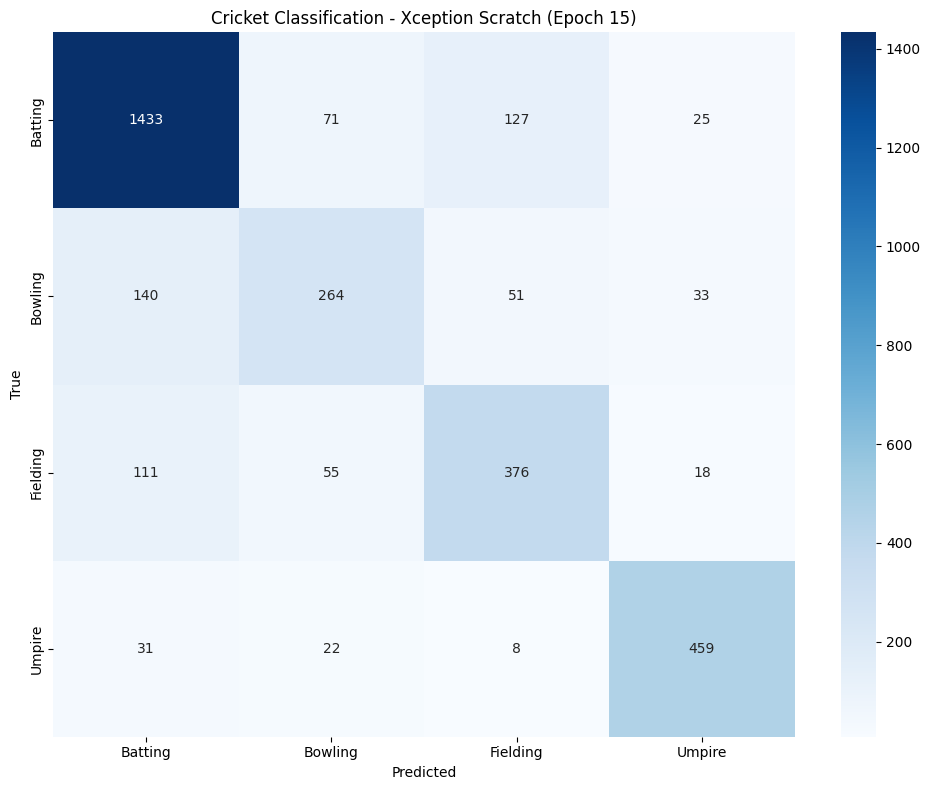

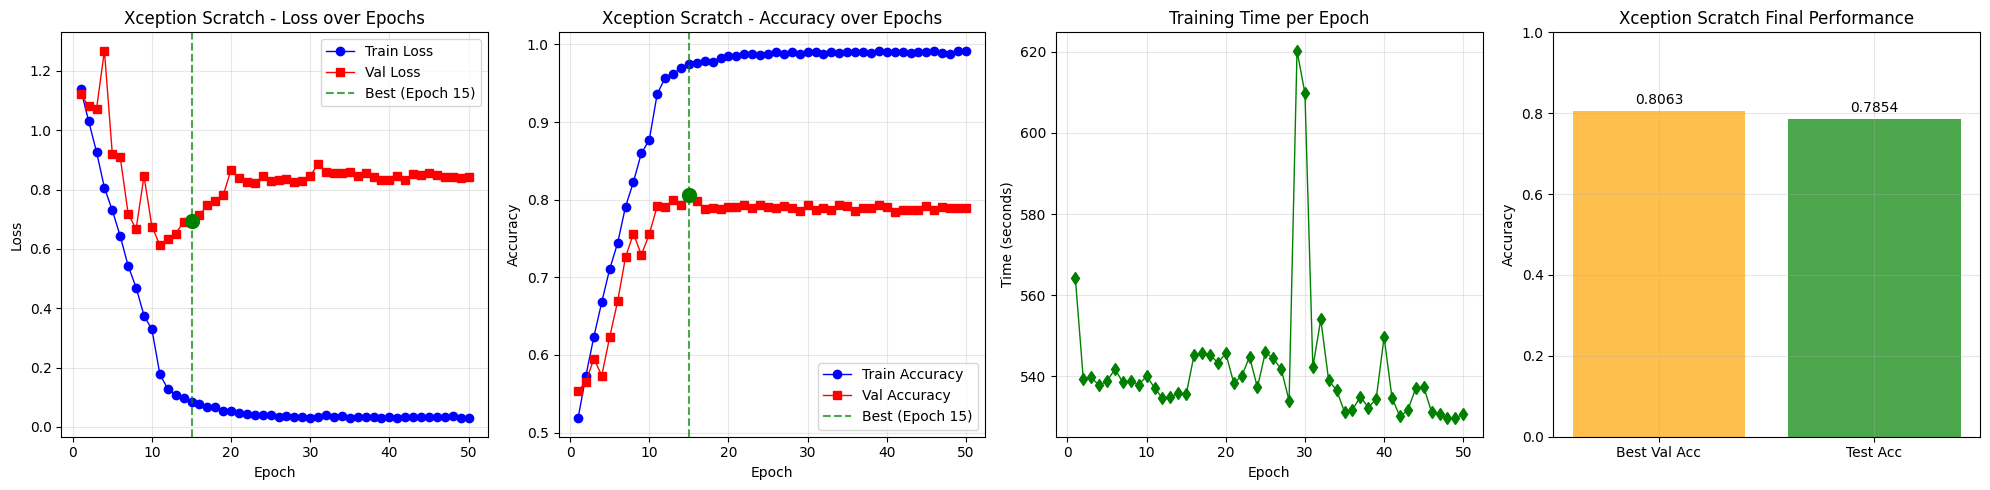


⏰ Final Timing Summary:
│ Total Training: 27082.53s (451.4 min)
│ Average per Epoch: 541.65s
│ Testing Time: 73.53s
│ Total Runtime: 27156.06s

🔀 Xception Scratch Training - Fixed Version:
│ ✅ Fixed inplace operations: All ReLU layers use inplace=False
│ ✅ Custom architecture: Built from ground up
│ ✅ Depthwise separable convolutions: Core Xception innovation
│ ✅ No transfer learning: Learns cricket features from scratch
│ ✅ Data augmentation: Robust training with limited data
│ ✅ Proper initialization: Xavier/He weight initialization
│ ✅ Learning rate scheduling: Adaptive learning rate decay
│ ✅ Clean dataset: 'random_occlusion' folder excluded
│ ✅ Gradient computation: Fixed backward pass issues


In [8]:

# -----------------------------
# 4. Training Setup for Scratch Training
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Higher LR for scratch training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay

print(f"\n📋 Training Configuration:")
print(f"│ Model: Xception (from scratch)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Weight Decay: 1e-4")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 16")
print(f"│ LR Scheduler: StepLR (decay every 10 epochs)")
print(f"│ Device: {device}")
print(f"│ Data: Filtered + Augmented")

# -----------------------------
# 5. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50  # More epochs needed for scratch training

# Initialize best model tracking (using val_acc for scratch training)
best_val_acc = 0.0
best_model_state = None
best_epoch = 0
best_val_loss = float('inf')

print(f"\n🚀 Starting Xception Training from Scratch for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Update learning rate
    scheduler.step()
    
    # Check if this is the best model (using val_acc for scratch training)
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_xception_scratch_filtered.pth')
    print(f"\n💾 Best model saved as 'best_cricket_xception_scratch_filtered.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times,
    'learning_rate': [scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']] * epochs
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_xception_scratch_filtered_history.csv', index=False)
print("\n💾 Training history saved to 'cricket_xception_scratch_filtered_history.csv'")

print(f"\n🎉 Xception Scratch Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 6. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (Xception - Scratch Training):")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"│ Training Type: From scratch (no pretraining)")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_xception_scratch_filtered.pth - Best model weights")
print(f"│ cricket_xception_scratch_filtered_history.csv - Training metrics")

# -----------------------------
# 7. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Xception Scratch (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=1)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=1)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Scratch - Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=1)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=1)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Scratch - Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
plt.plot(range(1, epochs+1), epoch_times, 'g-', marker='d', linewidth=1)
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Xception Scratch Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Training Info
print(f"\n🔀 Xception Scratch Training - Fixed Version:")
print(f"│ ✅ Fixed inplace operations: All ReLU layers use inplace=False")
print(f"│ ✅ Custom architecture: Built from ground up")
print(f"│ ✅ Depthwise separable convolutions: Core Xception innovation")
print(f"│ ✅ No transfer learning: Learns cricket features from scratch")
print(f"│ ✅ Data augmentation: Robust training with limited data")
print(f"│ ✅ Proper initialization: Xavier/He weight initialization")
print(f"│ ✅ Learning rate scheduling: Adaptive learning rate decay")
print(f"│ ✅ Clean dataset: '{ignore_folder}' folder excluded")
print(f"│ ✅ Gradient computation: Fixed backward pass issues")